In [2406]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt

In [2407]:
# Cargar los datos
data = pd.read_csv('processed_data_final.csv', parse_dates=['utc_timestamp'], index_col='utc_timestamp')


In [2408]:
missing_values = data.isnull().sum()
print(missing_values)

DE_solar_generation_actual               96
DE_wind_generation_actual                74
DE_load_actual_entsoe_transparency        0
DE_LU_price_day_ahead                 32853
dtype: int64


In [2409]:
# Imputar los valores faltantes con la media
data['DE_solar_generation_actual'] = data['DE_solar_generation_actual'].fillna(data['DE_solar_generation_actual'].mean())
data['DE_wind_generation_actual'] = data['DE_wind_generation_actual'].fillna(data['DE_wind_generation_actual'].mean())

# Interpolar los valores faltantes en DE_LU_price_day_ahead
data['DE_LU_price_day_ahead'] = data['DE_LU_price_day_ahead'].interpolate()

In [2410]:
missing_values = data.isnull().sum()
print(missing_values)

DE_solar_generation_actual                0
DE_wind_generation_actual                 0
DE_load_actual_entsoe_transparency        0
DE_LU_price_day_ahead                 32848
dtype: int64


In [2411]:
from sklearn.linear_model import LinearRegression

# Crear un dataframe donde la columna 'DE_LU_price_day_ahead' tiene valores no nulos
train_data = data.dropna(subset=['DE_LU_price_day_ahead'])

# Definir las variables predictoras
X_train_reg = train_data[['DE_solar_generation_actual', 'DE_wind_generation_actual', 'DE_load_actual_entsoe_transparency']]
y_train_reg = train_data['DE_LU_price_day_ahead']

# Entrenar el modelo de regresión
model_reg = LinearRegression()
model_reg.fit(X_train_reg, y_train_reg)

# Predecir los valores faltantes de la columna 'DE_LU_price_day_ahead'
X_missing = data[data['DE_LU_price_day_ahead'].isna()][['DE_solar_generation_actual', 'DE_wind_generation_actual', 'DE_load_actual_entsoe_transparency']]
y_pred_missing = model_reg.predict(X_missing)

# Reemplazar los valores faltantes con las predicciones
data.loc[data['DE_LU_price_day_ahead'].isna(), 'DE_LU_price_day_ahead'] = y_pred_missing

# Verificar que no haya más valores nulos
print(data.isnull().sum())

DE_solar_generation_actual            0
DE_wind_generation_actual             0
DE_load_actual_entsoe_transparency    0
DE_LU_price_day_ahead                 0
dtype: int64


In [2412]:
data.head(10)
data.describe()

,DE_solar_generation_actual,DE_wind_generation_actual,DE_load_actual_entsoe_transparency,DE_LU_price_day_ahead
count,50393.000000,50393.000000,50393.000000,50393.000000
mean,4566.042905,11552.542201,55494.673189,39.837465
std,6933.653610,9070.275795,10014.374825,15.771376
min,0.000000,135.000000,31307.000000,-90.010000
25%,0.000000,4510.000000,47107.000000,30.351271
50%,180.000000,9028.000000,55093.000000,39.810000
75%,7315.000000,16105.000000,64310.000000,49.998918
max,32947.000000,46064.000000,77549.000000,200.040000


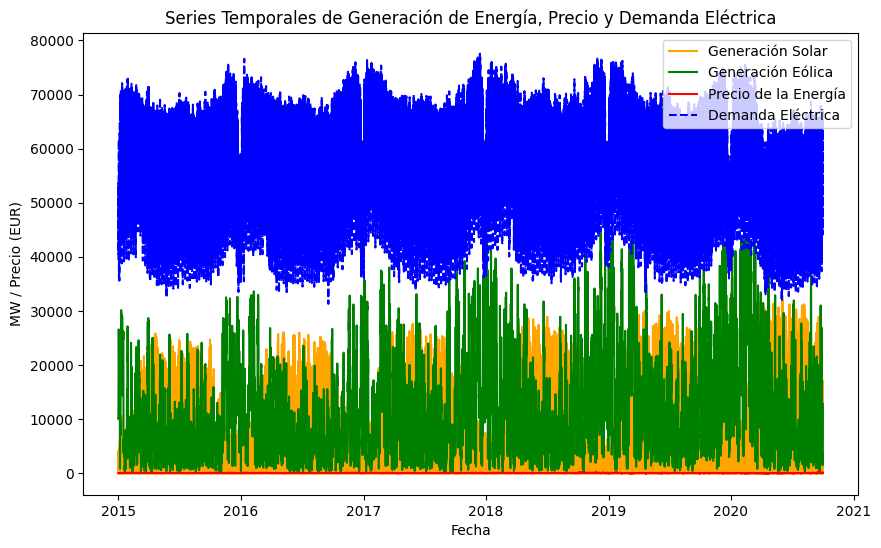

In [2413]:
# Asignar colores específicos a cada serie
plt.figure(figsize=(10, 6))
# Generación Solar en azul
plt.plot(data.index, data['DE_solar_generation_actual'], label='Generación Solar', color='orange')
# Generación Eólica en naranja
plt.plot(data.index, data['DE_wind_generation_actual'], label='Generación Eólica', color='green')
# Precio de la Energía en verde
plt.plot(data.index, data['DE_LU_price_day_ahead'], label='Precio de la Energía', color='red')
# Demanda Eléctrica en rojo (línea punteada)
plt.plot(data.index, data['DE_load_actual_entsoe_transparency'], label='Demanda Eléctrica', color='blue', linestyle='--')
# Título y etiquetas de los ejes
plt.title('Series Temporales de Generación de Energía, Precio y Demanda Eléctrica')
plt.xlabel('Fecha')
plt.ylabel('MW / Precio (EUR)')
plt.legend()
plt.show()

In [2414]:
data = data.resample('W').mean()

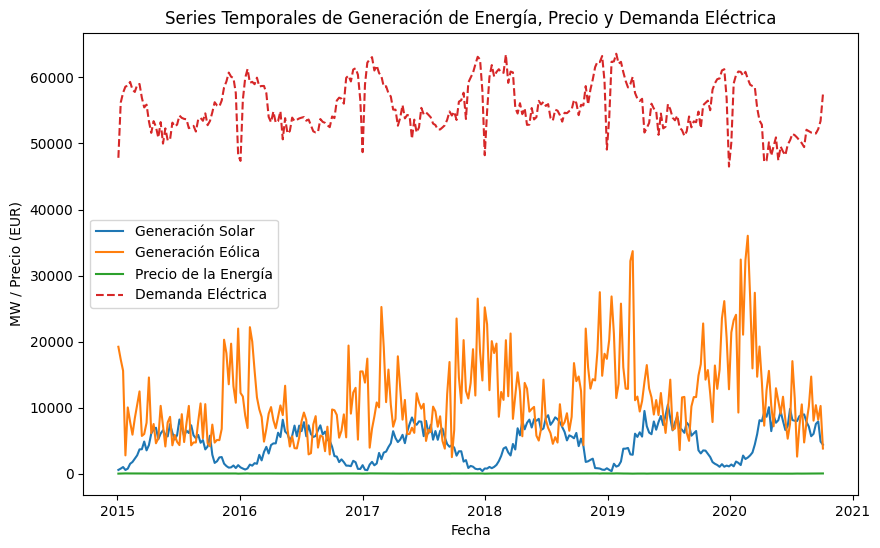

In [2415]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['DE_solar_generation_actual'], label='Generación Solar')
plt.plot(data.index, data['DE_wind_generation_actual'], label='Generación Eólica')
plt.plot(data.index, data['DE_LU_price_day_ahead'], label='Precio de la Energía')
plt.plot(data.index, data['DE_load_actual_entsoe_transparency'], label='Demanda Eléctrica', linestyle='--')
plt.title('Series Temporales de Generación de Energía, Precio y Demanda Eléctrica')
plt.xlabel('Fecha')
plt.ylabel('MW / Precio (EUR)')
plt.legend()
plt.show()

In [2416]:
# Separar características (X) y la variable objetivo (y)
X = data[['DE_solar_generation_actual', 'DE_wind_generation_actual','DE_LU_price_day_ahead']]
y = data['DE_load_actual_entsoe_transparency']

In [2417]:
# Dividir el conjunto de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)


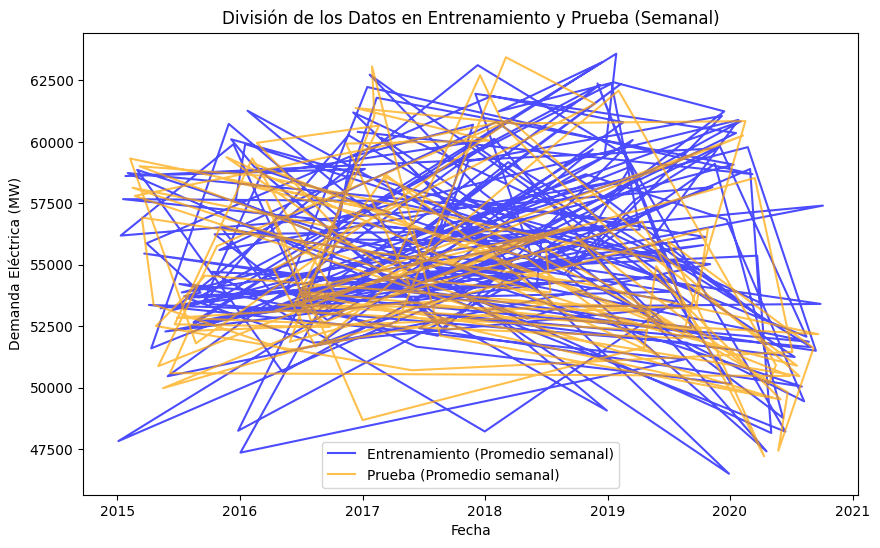

In [2418]:
# Graficar nuevamente después de ordenar
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Entrenamiento (Promedio semanal)', color='blue', alpha=0.7)
plt.plot(y_test.index, y_test, label='Prueba (Promedio semanal)', color='orange', alpha=0.7)
plt.title('División de los Datos en Entrenamiento y Prueba (Semanal)')
plt.xlabel('Fecha')
plt.ylabel('Demanda Eléctrica (MW)')
plt.legend()
plt.show()

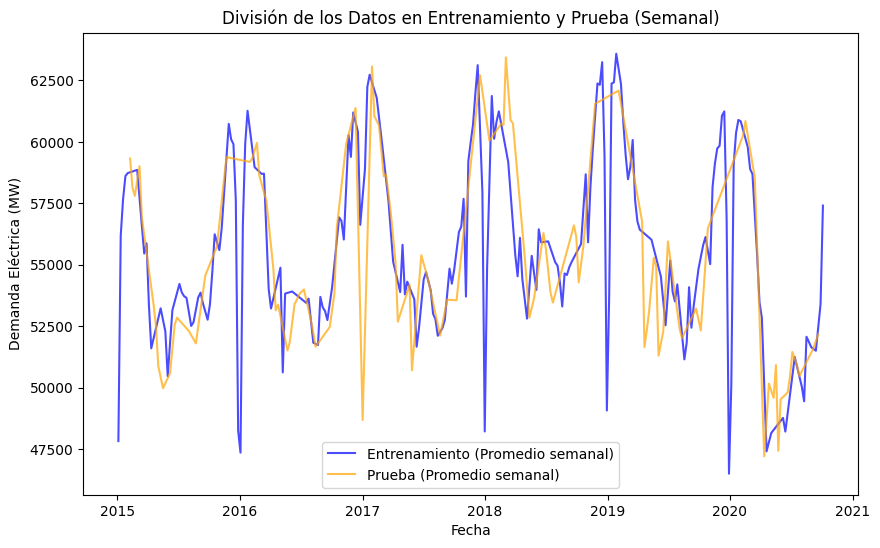

In [2419]:
# Datos estén ordenados por la fecha
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()


plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Entrenamiento (Promedio semanal)', color='blue', alpha=0.7)
plt.plot(y_test.index, y_test, label='Prueba (Promedio semanal)', color='orange', alpha=0.7)
plt.title('División de los Datos en Entrenamiento y Prueba (Semanal)')
plt.xlabel('Fecha')
plt.ylabel('Demanda Eléctrica (MW)')
plt.legend()
plt.show()

In [2420]:
print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

Conjunto de entrenamiento: (195, 3)
Conjunto de prueba: (106, 3)


Distribución de los datos

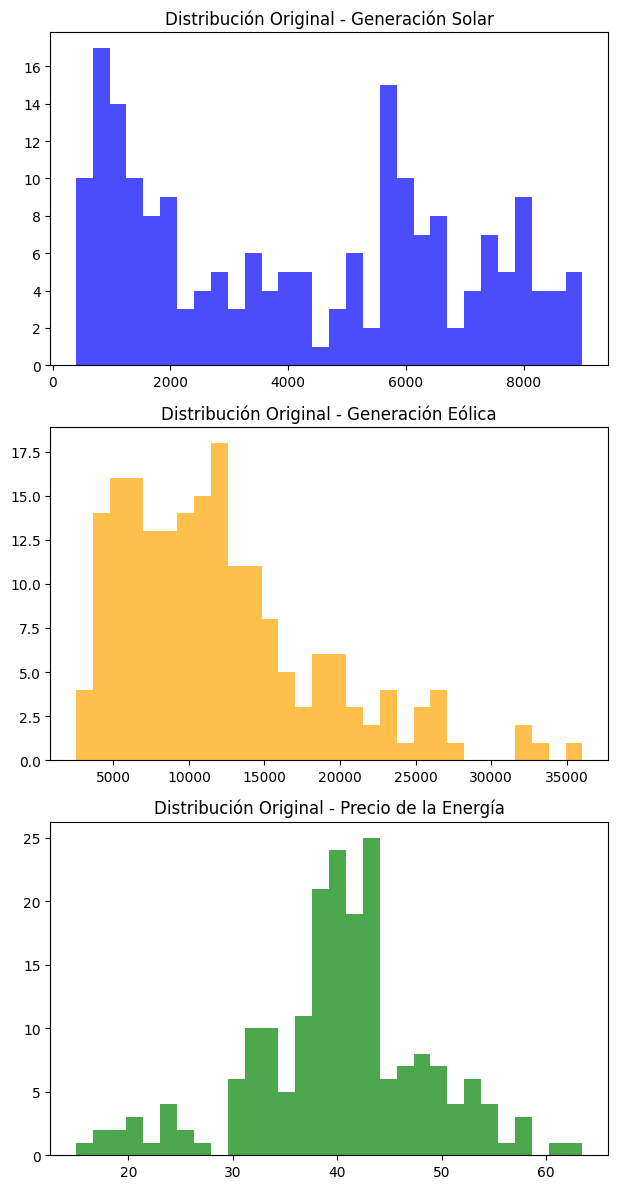

In [2421]:
plt.figure(figsize=(12, 12))

# Histograma para la Generación Solar (antes de la normalización)
plt.subplot(3, 2, 1)
plt.hist(X_train['DE_solar_generation_actual'], bins=30, color='blue', alpha=0.7)
plt.title('Distribución Original - Generación Solar')

# Histograma para la Generación Eólica (antes de la normalización)
plt.subplot(3, 2, 3)
plt.hist(X_train['DE_wind_generation_actual'], bins=30, color='orange', alpha=0.7)
plt.title('Distribución Original - Generación Eólica')

# Histograma para el Precio de la Energía (antes de la normalización)
plt.subplot(3, 2, 5)
plt.hist(X_train['DE_LU_price_day_ahead'], bins=30, color='green', alpha=0.7)
plt.title('Distribución Original - Precio de la Energía')

plt.tight_layout()
plt.show()

Aplicar método de normlaización de datos yeo-johnson y estandarizar los mismos con StandardScaler

Primeras filas de X_train escalado:
[[ 0.61958239 -0.03333874 -0.17222676]
 [ 1.1060565  -1.57674531 -0.02797733]
 [ 1.01887461 -0.1302143  -0.24161686]
 [-1.4599721   0.21564494  1.53912949]
 [-0.7701753   1.5698501  -0.92973992]]
Primeras filas de X_test escalado:
[[ 1.33591542 -0.07258719 -0.72095486]
 [ 1.26756586 -2.41489084 -0.53977392]
 [ 1.25045322 -0.29260968 -0.12304131]
 [ 0.20185776 -1.56616583  3.14523813]
 [-0.30662324 -0.13952019  0.92299245]]


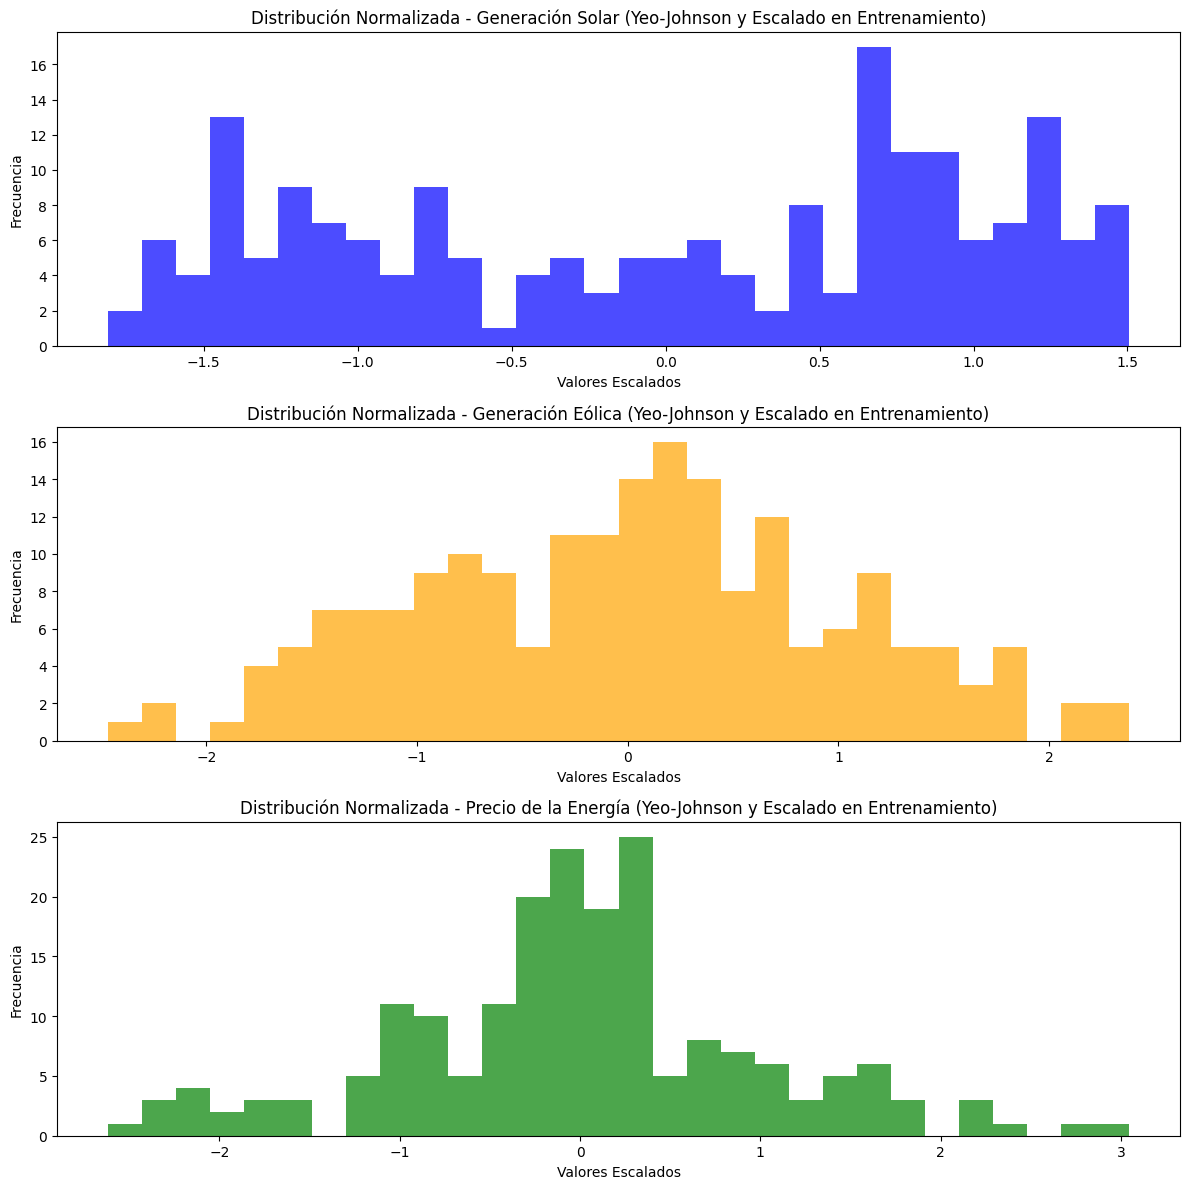

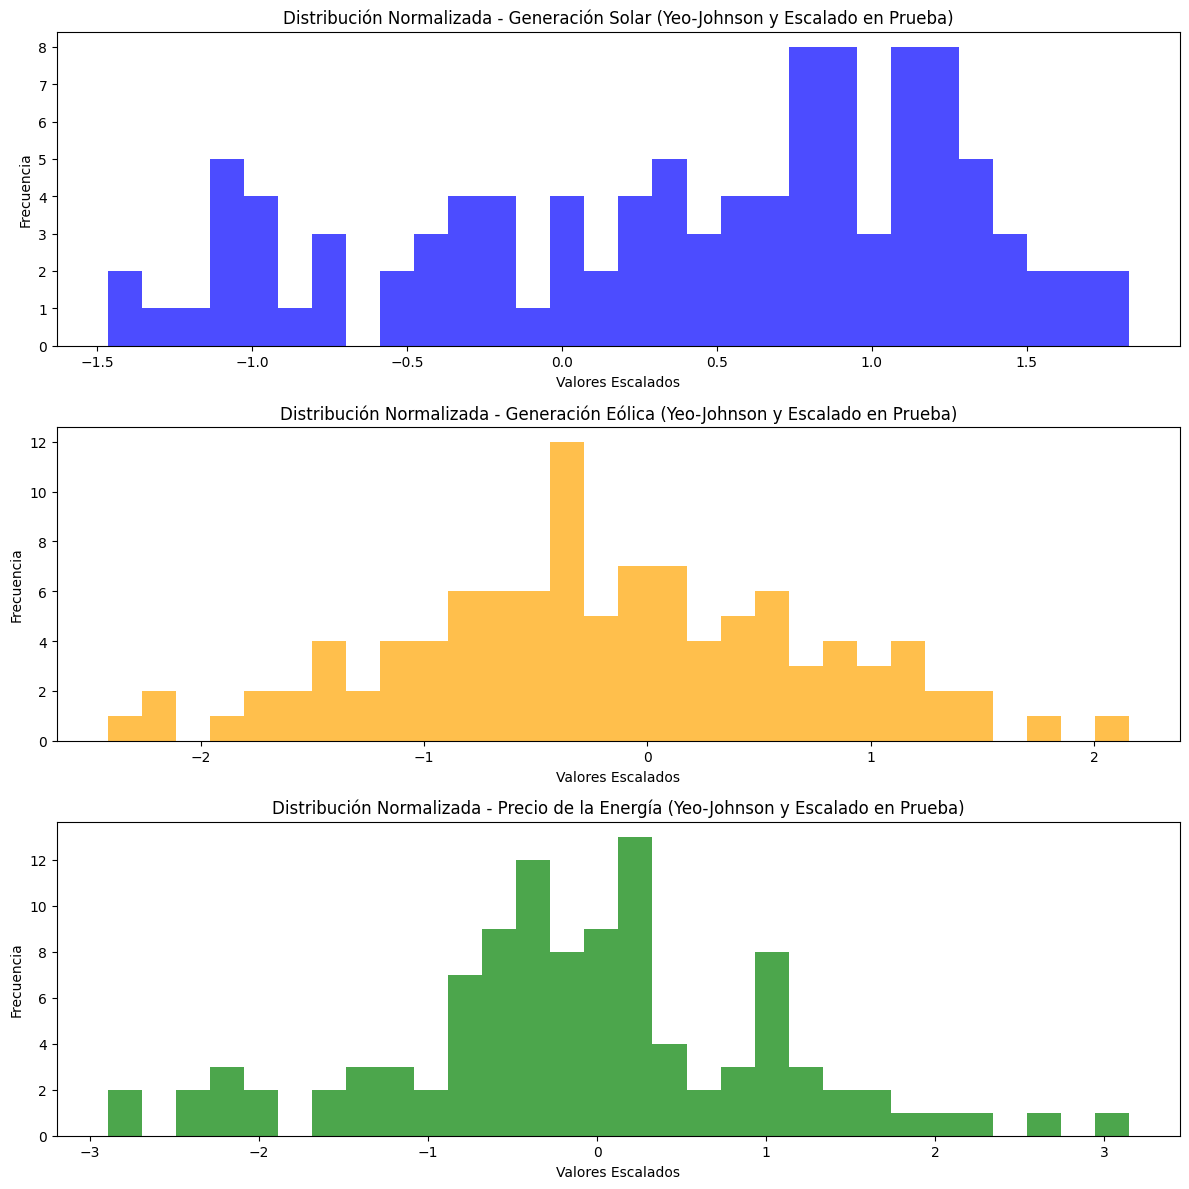

In [2422]:
from sklearn.preprocessing import PowerTransformer, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento (train) y prueba (test)
X_train, X_test, y_train, y_test = train_test_split(
    data[['DE_solar_generation_actual', 'DE_wind_generation_actual', 'DE_LU_price_day_ahead']],
    data['DE_load_actual_entsoe_transparency'],
    test_size=0.35,
    random_state=42
)

# Paso 1: Aplicar la transformación de Yeo-Johnson SOLO AJUSTANDO con X_train
transformer = PowerTransformer(method='yeo-johnson')
X_train_yeo_johnson = transformer.fit_transform(X_train)  # Ajustamos y transformamos X_train
X_test_yeo_johnson = transformer.transform(X_test)  # Solo transformamos X_test (sin volver a ajustar)

# Paso 2: Escalar los datos después de la transformación (ajustar solo con X_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_yeo_johnson)  # Ajustamos y escalamos X_train
X_test_scaled = scaler.transform(X_test_yeo_johnson)  # Solo escalamos X_test (sin volver a ajustar)

# Mostrar las primeras filas transformadas y escaladas
print("Primeras filas de X_train escalado:")
print(X_train_scaled[:5])

print("Primeras filas de X_test escalado:")
print(X_test_scaled[:5])

# Graficar las distribuciones de los datos de entrenamiento después de la transformación y el escalado
plt.figure(figsize=(12, 12))

# Generación Solar
plt.subplot(3, 1, 1)
plt.hist(X_train_scaled[:, 0], bins=30, color='blue', alpha=0.7)
plt.title('Distribución Normalizada - Generación Solar (Yeo-Johnson y Escalado en Entrenamiento)')
plt.xlabel('Valores Escalados')
plt.ylabel('Frecuencia')

# Generación Eólica
plt.subplot(3, 1, 2)
plt.hist(X_train_scaled[:, 1], bins=30, color='orange', alpha=0.7)
plt.title('Distribución Normalizada - Generación Eólica (Yeo-Johnson y Escalado en Entrenamiento)')
plt.xlabel('Valores Escalados')
plt.ylabel('Frecuencia')

# Precio de la Energía
plt.subplot(3, 1, 3)
plt.hist(X_train_scaled[:, 2], bins=30, color='green', alpha=0.7)
plt.title('Distribución Normalizada - Precio de la Energía (Yeo-Johnson y Escalado en Entrenamiento)')
plt.xlabel('Valores Escalados')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# También puedes graficar los datos de prueba si deseas:
plt.figure(figsize=(12, 12))

# Generación Solar (Prueba)
plt.subplot(3, 1, 1)
plt.hist(X_test_scaled[:, 0], bins=30, color='blue', alpha=0.7)
plt.title('Distribución Normalizada - Generación Solar (Yeo-Johnson y Escalado en Prueba)')
plt.xlabel('Valores Escalados')
plt.ylabel('Frecuencia')

# Generación Eólica (Prueba)
plt.subplot(3, 1, 2)
plt.hist(X_test_scaled[:, 1], bins=30, color='orange', alpha=0.7)
plt.title('Distribución Normalizada - Generación Eólica (Yeo-Johnson y Escalado en Prueba)')
plt.xlabel('Valores Escalados')
plt.ylabel('Frecuencia')

# Precio de la Energía (Prueba)
plt.subplot(3, 1, 3)
plt.hist(X_test_scaled[:, 2], bins=30, color='green', alpha=0.7)
plt.title('Distribución Normalizada - Precio de la Energía (Yeo-Johnson y Escalado en Prueba)')
plt.xlabel('Valores Escalados')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [2423]:
# Convertir los datos a formato DMatrix para XGBoost
train_dmatrix = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)

In [2424]:
# Parámetros del modelo
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'learning_rate': 0.1
}

In [2425]:
# Entrenar el modelo
xg_reg = xgb.train(params, train_dmatrix, num_boost_round=100)


In [2426]:

# Predecir
y_pred = xg_reg.predict(test_dmatrix)

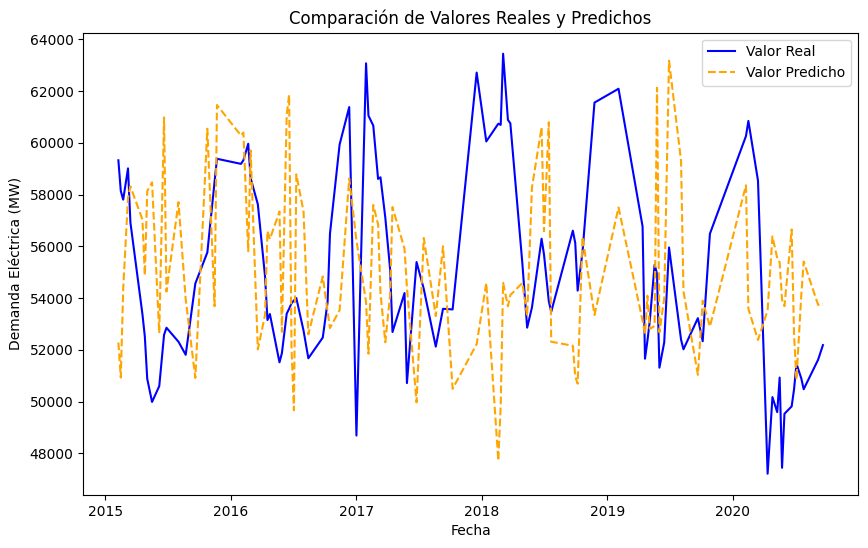

In [2427]:
# Datos estén ordenados por la fecha
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valor Real', color='blue')
plt.plot(y_test.index, y_pred, label='Valor Predicho', color='orange', linestyle='--')
plt.title('Comparación de Valores Reales y Predichos')
plt.xlabel('Fecha')
plt.ylabel('Demanda Eléctrica (MW)')
plt.legend()
plt.show()

In [2428]:
# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

mean_real_load = data['DE_load_actual_entsoe_transparency'].mean()
# Convertir MAE y RMSE en porcentaje del consumo promedio
mae_pct = (mae /mean_real_load ) * 100
rmse_pct = (rmse / mean_real_load) * 100

# Imprimir los resultados en porcentaje
print(f"Mean Absolute Error (MAE): {mae} ({mae_pct:.2f}% del consumo promedio)")
print(f"Root Mean Squared Error (RMSE): {rmse} ({rmse_pct:.2f}% del consumo promedio)")

Mean Absolute Error (MAE): 4139.357183218216
Root Mean Squared Error (RMSE): 4954.537917568813
Mean Absolute Error (MAE): 4139.357183218216 (7.46% del consumo promedio)
Root Mean Squared Error (RMSE): 4954.537917568813 (8.93% del consumo promedio)


Mejora del modelo

In [2429]:
# Parámetros base que se variarán
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

In [2430]:
# Rango de valores para los hiperparámetros
max_depth_range = [3, 5, 7, 10]  # Profundidad de los árboles
learning_rate_range = [0.01, 0.05, 0.1, 0.2]  # Tasa de aprendizaje
n_estimators_range = [50, 100, 200]  # Número de árboles

In [2431]:
# Variables para almacenar el mejor resultado
best_rmse = float('inf')
best_params = {}

# Lista para almacenar los resultados de RMSE
rmse_results = []

In [2432]:
# Lista para almacenar los resultados de RMSE
rmse_results = []

# Bucle que itera sobre los diferentes valores
for learning_rate in learning_rate_range:
    rmse_per_depth = []  # Almacenar RMSE para cada max_depth y learning_rate
    for max_depth in max_depth_range:
        rmse_sum = 0  # Sumar los RMSE para promediar sobre n_estimators
        for n_estimators in n_estimators_range:
            
            # Actualizar los parámetros
            params['max_depth'] = max_depth
            params['learning_rate'] = learning_rate
            params['n_estimators'] = n_estimators
            
            # Crear el modelo con los parámetros actuales
            model = xgb.XGBRegressor(**params)
            
            # Entrenar el modelo
            model.fit(X_train, y_train)
            
            # Hacer predicciones
            y_pred = model.predict(X_test)
            
            # Calcular el RMSE
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
            # Sumar el RMSE para esta combinación
            rmse_sum += rmse
            
            # Imprimir los resultados para este set de parámetros
            print(f"max_depth: {max_depth}, learning_rate: {learning_rate}, n_estimators: {n_estimators}, RMSE: {rmse}")
        
        # Almacenar el RMSE promedio sobre n_estimators para esta combinación de max_depth y learning_rate
        rmse_per_depth.append(rmse_sum / len(n_estimators_range))

max_depth: 3, learning_rate: 0.01, n_estimators: 50, RMSE: 3047.731359314306
max_depth: 3, learning_rate: 0.01, n_estimators: 100, RMSE: 2618.274847756283
max_depth: 3, learning_rate: 0.01, n_estimators: 200, RMSE: 2223.4795556790154
max_depth: 5, learning_rate: 0.01, n_estimators: 50, RMSE: 2910.811583375941
max_depth: 5, learning_rate: 0.01, n_estimators: 100, RMSE: 2399.644275449996
max_depth: 5, learning_rate: 0.01, n_estimators: 200, RMSE: 2036.9953262562362
max_depth: 7, learning_rate: 0.01, n_estimators: 50, RMSE: 2909.00757161685
max_depth: 7, learning_rate: 0.01, n_estimators: 100, RMSE: 2389.8053210055978
max_depth: 7, learning_rate: 0.01, n_estimators: 200, RMSE: 2011.2326679537348
max_depth: 10, learning_rate: 0.01, n_estimators: 50, RMSE: 2895.0230903637057
max_depth: 10, learning_rate: 0.01, n_estimators: 100, RMSE: 2365.0971765381623
max_depth: 10, learning_rate: 0.01, n_estimators: 200, RMSE: 1982.018839194094
max_depth: 3, learning_rate: 0.05, n_estimators: 50, RMSE: 2

In [2433]:
print(f"Tamaño de rmse_results: {len(rmse_results)}")
for i, result in enumerate(rmse_results):
    print(f"Resultados para learning_rate={learning_rate_range[i]}: {result}")

Tamaño de rmse_results: 0


In [2434]:
# Almacenar los RMSE para esta tasa de aprendizaje
rmse_results.append(rmse_per_depth)

In [2435]:
# Resultados finales
print(f"Mejor RMSE: {best_rmse}")
print(f"Mejores parámetros: {best_params}")

Mejor RMSE: inf
Mejores parámetros: {}


Tras encontrar los mejores ajustes para el modelo, haremos una validación cruzada.

In [2436]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import make_scorer, mean_squared_error

In [2437]:
# Definir el modelo con los mejores parámetros encontrados
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100
)

In [2438]:
# Definir el scorer usando RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

In [2439]:
# Ejecutar la validación cruzada (5 folds)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean s

In [2440]:
# Mostrar los resultados
print(f"RMSE en cada fold: {cv_scores}")
print(f"RMSE promedio: {cv_scores.mean()}")
print(f"Desviación estándar del RMSE: {cv_scores.std()}")

RMSE en cada fold: [1851.30605284 1559.22480417 2266.01875459 2774.72105335 2867.43178235]
RMSE promedio: 2263.740489459871
Desviación estándar del RMSE: 508.32942460828053


Optimizacion de hiperparametros 

In [2441]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [2442]:
# Definir los parámetros a ajustar
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0]
}

In [2443]:
# Definir el modelo
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

In [2444]:
# Implementar GridSearchCV con validación cruzada
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_root_mean_squared_error', cv=5, verbose=2, n_jobs=-1)

In [2445]:
# Entrenar con la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [2446]:
# Mostrar los mejores parámetros y el rendimiento
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor RMSE (cross-validation):", -grid_search.best_score_)

Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Mejor RMSE (cross-validation): 2171.4807512831308


Entremaniento final del modleo

In [2447]:
best_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    subsample=0.8
)

In [2448]:
# Entrenar el modelo con todo el conjunto de entrenamiento
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [2449]:
# Evaluar el rendimiento en el conjunto de prueba
y_pred = best_xgb_model.predict(X_test)

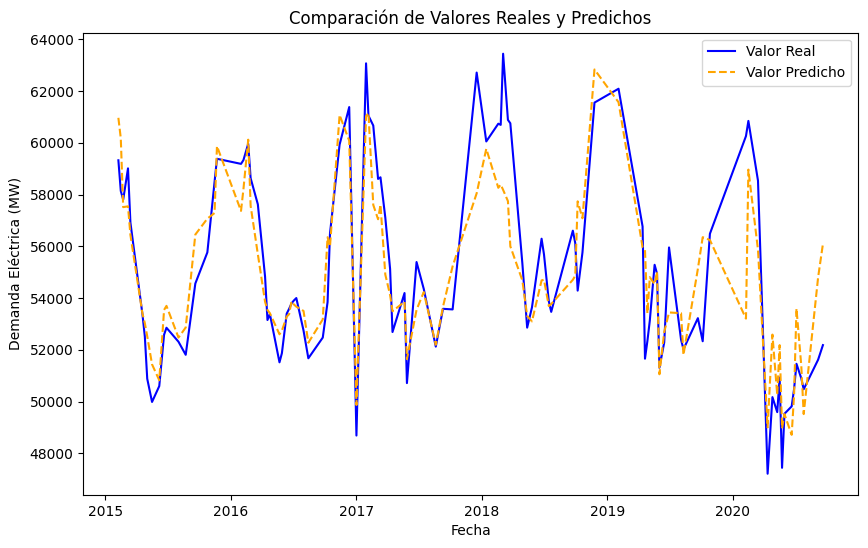

In [2450]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valor Real', color='blue')
plt.plot(y_test.index, y_pred, label='Valor Predicho', color='orange', linestyle='--')
plt.title('Comparación de Valores Reales y Predichos')
plt.xlabel('Fecha')
plt.ylabel('Demanda Eléctrica (MW)')
plt.legend()
plt.show()

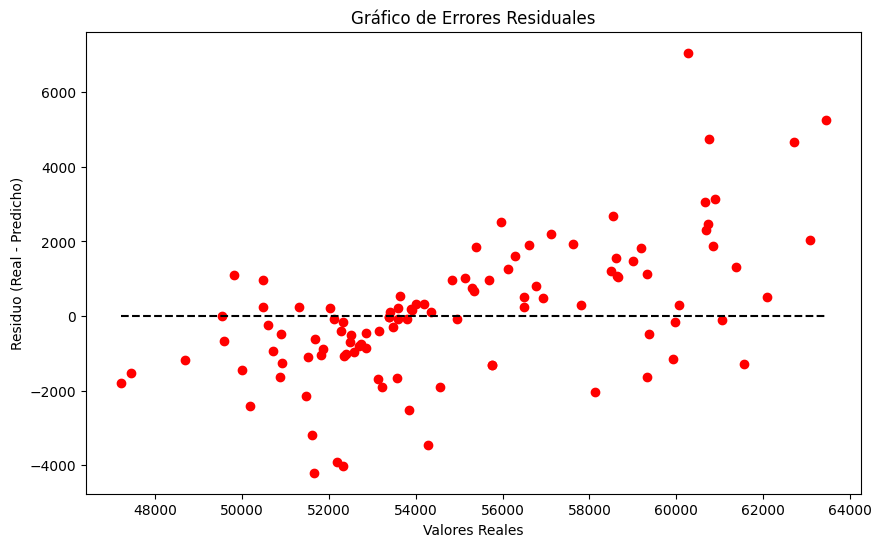

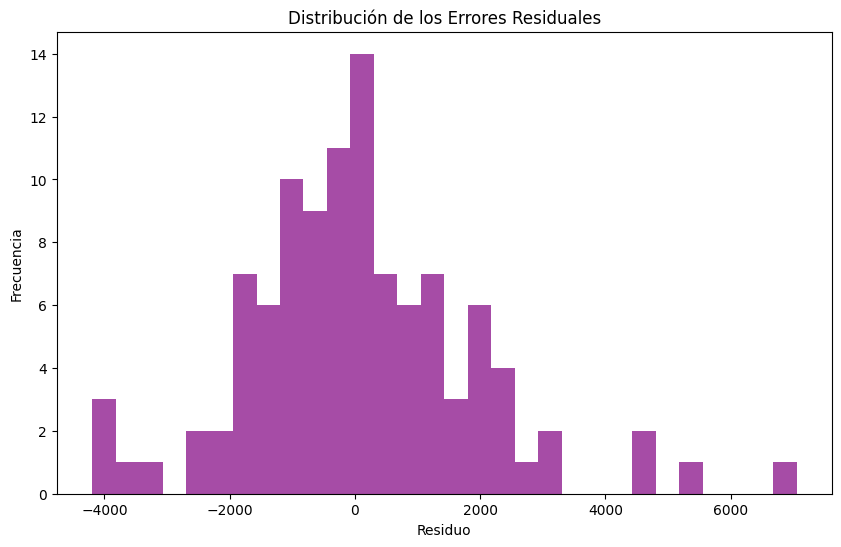

In [2451]:
# Gráfico de errores residuales
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='red')
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), color='black', linestyle='--')
plt.title('Gráfico de Errores Residuales')
plt.xlabel('Valores Reales')
plt.ylabel('Residuo (Real - Predicho)')
plt.show()

# Histograma de los errores residuales
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='purple', alpha=0.7)
plt.title('Distribución de los Errores Residuales')
plt.xlabel('Residuo')
plt.ylabel('Frecuencia')
plt.show()

In [2452]:
# Calcular las métricas de rendimiento
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [2453]:
print(f"Mean Absolute Error (MAE) en conjunto de prueba: {mae} MW")
print(f"Root Mean Squared Error (RMSE) en conjunto de prueba: {rmse}")

Mean Absolute Error (MAE) en conjunto de prueba: 1334.073197439353 MW
Root Mean Squared Error (RMSE) en conjunto de prueba: 1831.249378129549


In [2454]:
# Calcular el valor promedio del consumo eléctrico real
mean_real_load = data['DE_load_actual_entsoe_transparency'].mean()


In [2455]:
# Calcular el porcentaje de MAE y RMSE respecto al valor promedio de la demanda
mae_percentage = (mae / mean_real_load) * 100
rmse_percentage = (rmse / mean_real_load) * 100

In [2456]:
print(f"El MAE es el {mae_percentage:.2f}% del valor promedio de la demanda eléctrica.")
print(f"El RMSE es el {rmse_percentage:.2f}% del valor promedio de la demanda eléctrica.")

El MAE es el 2.40% del valor promedio de la demanda eléctrica.
El RMSE es el 3.30% del valor promedio de la demanda eléctrica.
